# Three-body scattering problem

The solution for the three-body scattering problem will again be based on OBEpot classes. 
Therefore, we repeat the methods for defining interaction and for fitting the interaction to the 
given bound state energy.

## Define a two-body interaction

I will work with a class that provides a method for the partial wave projection $V(p,p',l)$ of a bosonic 
interaction.   

A realistic test case is given by a OBE exchange interaction 
$$ V(\vec p, \vec p') = \frac{A}{2\pi} \frac{1}{(\vec p - \vec p')^2 + m_B^2} \exp\left(-\frac{(\vec p - \vec p')^2 + m_B^2}{\Lambda^2 }\right) + \frac{C_0}{4 \pi } \exp\left( - \frac{p^2+{p'}^2}{\Lambda^2}\right) $$ 


In [1]:
# for simplicity, we define the OBE exchange by numerical integration 
# and add one contact term to be determined using either a bound state or a scattering length 

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat



We use the fits of the last lectures to determine the parameters of this OBE interaction. 

In [2]:
parasets=[[300.0, -0.09827953494014054],
 [400.0, -0.028203145146196713],
 [500.0, -0.0004221894040945335],
 [600.0, 0.012857431330421717],
 [700.0, 0.020167185806378923],
 [800.0, 0.024707945457255083],
 [900.0, 0.027865200396659445],
 [1000.0, 0.030308007813785776],
 [1100.0, 0.03239034331482156],
 [1200.0, 0.03431611357447293]]

## Repeat the two-body bound state solver
The class for the calculation of the two-body bound state is added to check parameters and to provide 
the grid definitions for the two-body t-matrix. 

In [3]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of two-body solver. 
        
           The initialization defines the momentum grids and the interaction and partial wave to be used. 
           At this time, also the grid for Fourier transformation and for the Fourier transformed 
           wave function is given. 
           
           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb] 
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           mred -- reduces mass of the two bosons in MeV
           
           nr1 -- number of r points in interval [0,rb] 
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""
        
        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2 
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.l=l 

        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2 
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four 

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)
 
        # store grid points and weights for r space wave functions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)
        
        # store grid points and weights for Fourier trafo 
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)
        
        # store underlying interaction
        self.pot=pot
        
    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gaus-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight 

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # set up the matrix amat for which eigenvalues have to be calculated 
      amat=np.empty((self.npoints,self.npoints),dtype=np.double)
      for i in range(self.npoints):
        for j in range(self.npoints): 
          amat[i,j]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))*self.pot.v(self.pgrid[i],self.pgrid[j],self.l)*self.pweight[j]*self.pgrid[j]**2)

    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(amat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    # define solution as unnormalized wave function 
      wf=evec[:,maxpos]
    # and normalize 
      norm=np.sum(wf**2*self.pweight[0:self.npoints]*self.pgrid[0:self.npoints]**2)
      wf=1/np.sqrt(norm)*wf
    
      return eigv,self.pgrid[0:self.npoints],wf

    
    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
            
        return e1,eta1,pgrid,wf 
           
    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.
        
           Parameter: 
           wfp -- wave function in momentum space
            
           Note that the factor I**l is omitted."""
        
        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points  
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        # evaluate jl     
        jlmat = spherical_jn(self.l,rpmat)
        
        # interpolate of wave to denser Fourier trafo grid
        wfinter = interp1d(self.pgrid, wfp, kind='cubic',fill_value="extrapolate")
        # interpolate wf and multiply my p**2*w elementwise 
        wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)
        
        # now the Fourier trafo is a matrix-vector multiplication 
        wfr = jlmat.dot(wfdense)
        
        return self.rgrid,wfr
    
    
    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.
        
           Normalization of the wave function is assumed. 
           Parameter: 
           wfr -- wave function in r-space obtained by previous Fourier trafo"""
        
        
        norm=np.sum(wfr**2*self.rweight*self.rgrid**2)
        rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

            
        rms=np.sqrt(rms)
        
        return norm,rms
    
    
        

Use this to calc binding energies ...

In [4]:
# go through parameters of fit
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    # perform energy search for this parameter set
    ener,lam,pmom,wf=solver.esearch(neigv=1,e1=-2.0/TwoBody.hbarc,e2=-2.5/TwoBody.hbarc)
    
    # get Fourier trafo (together with r grid points)
    rp,wfr=solver.fourier(wf)
    # calculate norm and rms radius (deviation of the norm from 1 gives idea of accuracy)
    norm,rms=solver.rms(wfr)
    
    # print energy, eigenvalue (should be one), norm and 1/2 rms (= radius to the CM for equal mass particles)
    print("{0:15.6e}   {1:15.6e}  {2:15.6e}   {3:15.6e}".format(ener*TwoBody.hbarc,lam, norm, rms/2.0)) #rms is printed for distance to CM assuming equal masses



  -2.224997e+00      1.000000e+00  9.997794e-01+0.000000e+00j   2.096766e+00+0.000000e+00j
  -2.224993e+00      1.000000e+00  9.997841e-01+0.000000e+00j   2.069329e+00+0.000000e+00j
  -2.224990e+00      1.000000e+00  9.997849e-01+0.000000e+00j   2.064349e+00+0.000000e+00j
  -2.224991e+00      1.000000e+00  9.997849e-01+0.000000e+00j   2.064681e+00+0.000000e+00j
  -2.224992e+00      1.000000e+00  9.997846e-01+0.000000e+00j   2.066091e+00+0.000000e+00j
  -2.224992e+00      1.000000e+00  9.997844e-01+0.000000e+00j   2.067504e+00+0.000000e+00j
  -2.224993e+00      1.000000e+00     9.997843e-01      2.068679e+00
  -2.224994e+00      1.000000e+00  9.997842e-01+0.000000e+00j   2.069602e+00+0.000000e+00j
  -2.224994e+00      1.000000e+00  9.997841e-01+0.000000e+00j   2.070315e+00+0.000000e+00j
  -2.224991e+00      1.000000e+00  9.997840e-01+0.000000e+00j   2.070864e+00+0.000000e+00j


looks good! 

## Three-Body scattering state

Now comes the new aspects of the three-body scattering problem. 

### Off-shell t-matrix

The first part is the calculation of the off-shell two-body t-matrix. The equation to be solved is 
$$ t(p,p',E') = V(p,p') +  \int_0^\infty dp'' {p''}^2 V(p,p'') \frac{1}{E + i \varepsilon-\frac{{p''}^2}{2 \mu}} t(p'',p',E') $$
where the energy is given by $E'=E - 0.75\,q^2/m$ by the energy of the three-body system and the kinetic energy of the spectator.
The implementation is done as an extension of the two-body bound state class so that some of the previous routines can be reused. 
The initialization just adds points for the spectator momentum (and also for the definition of a Fourier transformed wave function). For the bound state problem, we do not need to take any singularity into account since $E$ is negative.

In [5]:
# next extend the class for twobody to scattering 
from scipy.special import legendre

class TwoBodyTMat(TwoBody):
    """This class defines the off-shell t-matrix for a three-body scattering state.
    
       The class assumes three identical particles. It also contains the 
       initialization of grid points for the three-body problem. 
    """
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, 
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0, 
                            mass=938.92,lmax=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            nrho1=20, nrho2=10, rhoa=1.0, rhob=5.0, rhoc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of grid points and interaction for the solution of the three-body problem. 
        
           Parameter: 
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of p grid points in interval [0,pb] 
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           nq1 -- number of q grid points in interval [0,qb] 
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above 
           qc  -- upper integration boundary for the solution of the integral equation 
           mass -- particle mass of the three identical bosons in MeV
           
           nr1 -- number of r (related to p) points in interval [0,rb] 
           nr2 -- number of r (related to p) points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,ra]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           nrho1 -- number of rho (related to q) points in interval [0,rhob] 
           nrho2 -- number of rho (related to q) points in interval [rhob,rhoc]
           rhoa  -- half of np1 points are in interval [0,rhoa]
           rhob  -- interval boundary as defined above 
           rhoc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo
           
           lmax  -- maximal two-body angular momentum to be taken into account
           """
        
        
        # first use the TwoBody class to keep the main parameters 
        super().__init__(pot,np1,np2,pa,pb,pc,mass/2,0,nr1,nr2,ra,rb,rc,np1four,np2four)

        self.nq1 = nq1
        self.nq2 = nq2
        self.nqpoints  = nq1+nq2 
        self.mass=mass/self.hbarc
        self.qa=qa
        self.qb=qb
        self.qc=qc
        self.lmax=lmax 

        self.nrho1 = nrho1
        self.nrho2 = nrho2
        self.nrhopoints  = nrho1+nrho2 
        self.rhoa=rhoa
        self.rhob=rhob
        self.rhoc=rhoc


        # store grid points and weights for integral equations
        self.qgrid,self.qweight = self._trns(self.nq1,self.nq2,self.qa,self.qb,self.qc)
 
        # store grid points and weights for r space wave functions
        self.rhogrid,self.rhoweight = self._trns(self.nrho1,self.nrho2,self.rhoa,self.rhob,self.rhoc)
        
        # store grid points and weights for Fourier trafo 
        self.qfourgrid,self.qfourweight = self._trns(self.np1four,self.np2four,self.qa,self.qb,self.qc)
        
        # finally extend p grid points to treat on-shell point 
        # append one momentum to grid for the onshell value
        # value will be defined during solution in lseq below
        self.pgrid=np.append(self.pgrid,[0.0])

        # also the on-shell momentum of the 2-1 scattering state is added as 
        # the last momentum of the q array
        # value will be defined during solution in lseq below
        self.qgrid=np.append(self.qgrid,[0.0])

        # finally, we assume that the two-body system only has an s-wave bound state. 
        # we determine the corresponding energy and wave function 
        
        # perform energy search for this parameter set
        self.ed,lam,pmom,self.wfd=self.esearch(neigv=1,e1=-2.0/self.hbarc,e2=-2.5/self.hbarc)

        print("Initialized two-body t-matrix. Found two-body energy: {0:15.6e} MeV".format(self.ed*self.hbarc))
        
# now turn to scattering and solve for LS equation to get tmatrix (on- and offshell)
    def prep_tmat(self,E):
      """Prepares all necessary t-matrix elements up to l=lmax.
      
         Starts the calculation of the t-matrix for a given three-body energy. 
      """  
      # find the corresponding on-shell momentum in the 2+1 system 
      # qon should be positive (threshold is self.ed)
      qon=np.sqrt(4*self.mass/3*(E-self.ed))
      self.qgrid[self.nqpoints]=qon 
    
      print("Start calculating tmatrix for on-shell momentum q0 = {0:15.6e} fm-1".format(qon))
        
      # prepare off-shell energies for t-matrix 
      etmat=E-0.75*self.qgrid**2/self.mass   # note that this is a negative energy < E_b(two-body) 
             
      # prepare numpy array that keeps all tmatrix elements 
      # put to zero to treat pon for negative energies properly
      tmat=np.zeros((self.lmax//2+1,self.nqpoints+1,self.npoints+1,self.npoints+1),dtype=np.cdouble)
      
      # now I need to solve the Lippmann-Schwinger equation for each etmat and each l =0,..,lmax
      # take only even partial waves because of Pauli principle  
      for l in range(0,self.lmax+1,2):
        print("Calculating for l = {0:d}".format(l))    
        for ie in range(self.nqpoints+1): 
          # on-shell momentum for this off-shell energy
          if etmat[ie] > 0:
           pon=np.sqrt(2*self.mred*etmat[ie])
           self.pgrid[self.npoints]=pon
          else:
           pon=0.0
           self.pgrid[self.npoints]=pon
            
          # define matrix for set of equations 
          # predefine the Kronecker deltas 
          amat=np.identity(self.npoints+1,dtype=np.cdouble)
          # now add the other pieces of the definition of the matrix   
          for i in range(self.npoints+1):
            # first for j != N 
            if self.pgrid[i]>0:
             for j in range(self.npoints):   
              amat[i,j]+=-(2*self.mred)*self.pot.v(self.pgrid[i],self.pgrid[j],self.l)*self.pgrid[j]**2 \
                               /(2*self.mred*etmat[ie]-self.pgrid[j]**2)*self.pweight[j] 
            # then for j==N
            if self.pgrid[i]>0 and pon>0:
             amat[i,self.npoints]  \
               +=(2*self.mred)*self.pot.v(self.pgrid[i],pon,self.l)*pon**2* \
                  np.sum(self.pweight[0:self.npoints-1]/(pon**2-self.pgrid[0:self.npoints-1]**2))  \
                 +1j*m.pi*self.mred*pon*self.pot.v(self.pgrid[i],pon,self.l)  \
                -self.mred*pon*self.pot.v(self.pgrid[i],pon,self.l)*np.log(abs((pon+self.pc)/(self.pc-pon)))
        
          # now define the rhs   
          bmat=np.empty((self.npoints+1,self.npoints+1),dtype=np.cdouble)
          for i in range(self.npoints+1):
            for j in range(self.npoints+1):
               if self.pgrid[i]>0 and self.pgrid[j]>0:
                 bmat[i,j]=self.pot.v(self.pgrid[i],self.pgrid[j],self.l)
               else:
                 bmat[i,j]=0.0
                    
          # finally solve set of equations and store in complete array
          # also multiply by (q0**2-q)
          # special treatment for l=0 and q=q0 (in this case, the equation is not solvable 
          # but the t matrix is analytically known, etmat is negative = Ed in this case)
          if l==0 and ie==self.nqpoints:
            # use tilde t = (Ed-H0)|phi> <phi|(E-H0)     
            for i in range(self.npoints):
              for j in range(self.npoints):
                tmat[l//2,ie,i,j]=(self.ed-self.pgrid[i]**2/self.mass)  \
                                       *self.wfd[i]*self.wfd[j] \
                                       *(self.ed-self.pgrid[j]**2/self.mass)
          else:      
            tmat[l//2,ie,:,:]=np.linalg.solve(amat,bmat)*0.75*(qon**2-self.qgrid[ie]**2)/self.mass
                      
      print("Finished calculating tmatrix for on-shell momentum q0 = {0:15.6e} fm-1".format(self.qgrid[self.nqpoints]))

      # return on- and off-shell t-matrix   
      return tmat
            


In [6]:
# now test the module 
para=[700.0, 0.020167185806378923]
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
tmatsolver=TwoBodyTMat(pot=pot,
                 np1=20,np2=10,pa=1.0,pb=7.0,pc=20.0,
                 nq1=20,nq2=10,qa=1.0,qb=7.0,qc=20.0,
                 mass=938.92,lmax=2,
                 nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                 np1four=400,np2four=200)
tmat=tmatsolver.prep_tmat(E=tmatsolver.ed+0.75*(1.0)**2/tmatsolver.mass)

Initialized two-body t-matrix. Found two-body energy:   -2.225000e+00 MeV
Start calculating tmatrix for on-shell momentum q0 =    1.000000e+00 fm-1
Calculating for l = 0
Calculating for l = 2
Finished calculating tmatrix for on-shell momentum q0 =    1.000000e+00 fm-1


### Spline interpolation
For the interpolation, it is necessary to find a representation of the interpolated function that can be expressed 
as a sum 
$$ f(x) = \sum_{i=0}^{n-1} f(x_i) \ S_i(x) $$ 
where $x_i$ are defined a priori. $S_i(x)$ needs to be defined only based on $x$ and $x_i$. 
We will use here a simple ansatz: for $x_{i+1}>x>x_i$, we will use the grid points $x_{i-1}$, $x_{i}$$x_{i+1}$  and  $x_{i+2}$ 
to define 
\begin{eqnarray}
S_{i-1}(x)& =& -\phi_3(x) \frac{x_{i+1}-x_{i}}{(x_{i}-x_{i-1})(x_{i+1}-x_{i-1})} \\
S_{i}(x)& =& \phi_1(x) + \phi_3(x) \left( \frac{x_{i+1}-x_{i}}{(x_{i}-x_{i-1})(x_{i+1}-x_{i-1})} - \frac{x_{i}-x_{i-1}}{(x_{i+1}-x_{i})(x_{i+1}-x_{i-1})} \right) - \phi_4(x) \frac{x_{i+2}-x_{i+1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i})}\\
S_{i+1}(x)& =& \phi_2(x) + \phi_3(x) \frac{x_{i}-x_{i-1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i-1})}  + \phi_4(x)  \left( \frac{x_{i+2}-x_{i+1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i})} - \frac{x_{i+1}-x_{i}}{(x_{i+2}-x_{i+1})(x_{i+2}-x_{i})} \right)
\\
S_{i+2}(x)& =& \phi_4(x) \frac{x_{i+1}-x_{i}}{(x_{i+2}-x_{i+1})(x_{i+2}-x_{i})} \\
\end{eqnarray}
where 
\begin{eqnarray}
\phi_{{1}} \left( x \right) & = & {\frac { \left( x_{{i+1}}-x \right) ^{2}
 \left( x_{{i+1}}-3\,x_{{i}}+2\,x \right) }{ \left( x_{{i+1}}-x_{{i}}
 \right) ^{3}}} \\
\phi_{{2}} \left( x \right) & = & {\frac { \left( x_{{i}}-x \right) ^{2}
 \left( 3\,x_{{i+1}}-x_{{i}}-2\,x \right) }{ \left( x_{{i+1}}-x_{{i}}
 \right) ^{3}}} \\
\phi_{{3}} \left( x \right) & = & {\frac { \left( x-x_{{i}} \right) 
 \left( x_{{i+1}}-x \right) ^{2}}{ \left( x_{{i+1}}-x_{{i}} \right) ^{
2}}} \\
\phi_{{4}} \left( x \right) & = & {\frac { \left( x-x_{{i+1}} \right) 
 \left( x_{{i}}-x \right) ^{2}}{ \left( x_{{i+1}}-x_{{i}} \right) ^{2}
}} \\
\end{eqnarray}
are polynomials with 
\begin{eqnarray}
\phi_2(x_{i})& = & \phi_3(x_{i})=\phi_4(x_{i})=0 \\
\phi_1'(x_{i}) &= & \phi_2'(x_{i})=\phi_4'(x_{i})=0 \\ 
\phi_1(x_{i+1})& = & \phi_3(x_{i+1})=\phi_4(x_{i+1})=0 \\
\phi_1'(x_{i+1}) &= & \phi_2'(x_{i+1})=\phi_3'(x_{i+1})=0 \\ 
\end{eqnarray}
and 
\begin{eqnarray}
\phi_1(x_{i})& = & \phi_2(x_{i+1})=\phi_3'(x_{i})=\phi_4'(x_{i+1})=1 \\
\end{eqnarray}






In [7]:
import numpy as np
# prepare interpolation using cubic hermitian splines 

class Cubherm:
    """Prepares spline functions for cubic hermitian splines. 
    
    see Hueber et al. FBS 22,107 (1997). 
    
    The function spl returns the the spline function for a given x. 
    If x is below the smallest grid point, extrapolation is used. 
    If x is after largest grid point, then the function evaluates to zero. 
    """
    
        
    def spl(xold,xin):
        """Calculates spline functions for given values xold and xnew.
        
           Parameters:
           xold -- set of grid points where function is given. xold needs to be one dimensional.
           xin  -- set of grid points to interpolate to. xnew can be multidimensional. 
           
           On return spline functions will be given that have the shape of xnew and xold combined. 
        """
        
        # first determine the base value of the index for each xnew.
        
        nold=len(xold)
        if nold<4:
          raise(ValueError("Interpolation requires at least 4 grid points.")) 
        
        xnew=xin.reshape((-1))        
        indx=np.empty((len(xnew)),dtype=np.int)
        
        for i in range(len(xnew)):
          # do not extrapolated beyond largest grid point
          if xnew[i] > xold[nold-1]: 
            indx[i]=-1
          else:  
            for j in range(nold):
              if xnew[i] <= xold[j]:
                break          
            if j < 1:
              indx[i]=0
            elif j > nold-3:
              indx[i]=nold-3
            else:
              indx[i]=j-1  

        # then prepare phi polynomials for each x 
        
        phi1=np.zeros((len(xnew)),dtype=np.double)
        phi2=np.zeros((len(xnew)),dtype=np.double)
        phi3=np.zeros((len(xnew)),dtype=np.double)
        phi4=np.zeros((len(xnew)),dtype=np.double)
        
        for i in range(len(xnew)):
          if indx[i]>0:  
            phi1[i] = (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (xold[indx[i] + 1] - 3 * xold[indx[i]] + 2 * xnew[i])
            phi2[i] = (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (3 * xold[indx[i] + 1] - xold[indx[i]] - 2 * xnew[i])
            phi3[i] = (xnew[i] - xold[indx[i]]) * (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
            phi4[i] = (xnew[i] - xold[indx[i] + 1]) * (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
        
        # now we are ready to prepare the spline functions 
        # most are zero 
        splfu=np.zeros((len(xold),len(xnew)),dtype=np.double)
        for i in range(len(xnew)):
          if indx[i]>0:  
            splfu[indx[i]-1,i] = \
               -phi3[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]]-xold[indx[i]-1])*(xold[indx[i]+1]-xold[indx[i]-1]))
            
            splfu[indx[i],i] = phi1[i] \
                +phi3[i]*((xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]]-xold[indx[i]-1]) \
                         -(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]]))/(xold[indx[i]+1]-xold[indx[i]-1]) \
                -phi4[i]*(xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+2]-xold[indx[i]])

            splfu[indx[i]+1,i] = phi2[i] \
                +phi3[i]*(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+1]-xold[indx[i]-1]) \
                +phi4[i]*((xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]]) \
                         -(xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]+2]-xold[indx[i]+1]))/(xold[indx[i]+2]-xold[indx[i]])
            
            
            splfu[indx[i]+2,i] = \
                phi4[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]+2]-xold[indx[i]+1])*(xold[indx[i]+2]-xold[indx[i]]))
          elif indx[i]>=0:
            # do linear interpolation at the origin 
            splfu[indx[i],i] = (xnew[i]-xold[indx[i]+1])/(xold[indx[i]]-xold[indx[i]+1]) 
            splfu[indx[i]+1,i] = (xold[indx[i]]-xnew[i])/(xold[indx[i]]-xold[indx[i]+1]) 

        retshape=[nold] 
        for n in list(np.shape(xin)):
          retshape.append(n)
        
        return splfu.reshape(retshape)
    

The following cell is just for testing the interpolation routines. 

   1.000000e-02     5.149358e-06    9.999000e-02 
   1.905025e-01    -1.461695e-05    9.980920e-02 
   3.710050e-01     2.346370e-04    9.960371e-02 
   5.515075e-01     2.671462e-04    9.917095e-02 
   7.320101e-01    -3.325779e-04    9.776651e-02 
   9.125126e-01    -7.852833e-04    9.368293e-02 
   1.093015e+00     2.516656e-05    8.450394e-02 
   1.273518e+00    -1.688499e-03    6.920928e-02 
   1.454020e+00    -1.215464e-03    5.067225e-02 
   1.634523e+00     2.919026e-03    3.384228e-02 
   1.815025e+00     1.898543e-03    2.146401e-02 
   1.995528e+00    -2.104937e-03    1.340116e-02 
   2.176030e+00    -3.691891e-03    8.423003e-03 
   2.356533e+00    -2.222634e-03    5.388626e-03 
   2.537035e+00     7.978989e-04    3.523988e-03 
   2.717538e+00     1.397672e-03    2.357726e-03 
   2.898040e+00     3.687842e-04    1.612567e-03 
   3.078543e+00    -8.034412e-04    1.125867e-03 
   3.259045e+00    -1.523899e-03    8.011142e-04 
   3.439548e+00    -1.649727e-03    5.800150e-04 


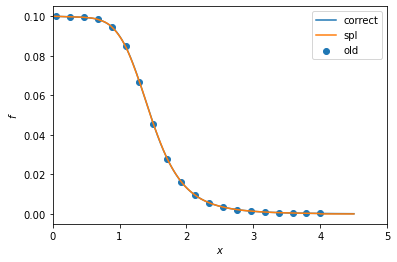

In [8]:
# test the function above 
import matplotlib.pyplot as plt

# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f$')
ax.set_xlim([0,5])
def testfu(x):
    return 1.0/(10.0+x**6)*np.exp(-0.01*x)

xold = np.linspace(0.05,4,20)
                
fold =testfu(xold)
                
                
# xnew = np.outer(np.linspace(0.01,4.5,5),np.linspace(0.01,4.5,10))
xnew = np.linspace(0.01,4.5,200) 
fnew=testfu(xnew)

spl=Cubherm.spl(xold,xnew)
fspl=np.zeros(xnew.shape,dtype=np.double)
for n in range(len(xold)):
  fspl=fspl+spl[n,:]*fold[n]

xprint=xnew.reshape(-1)
fsplprint=fspl.reshape(-1)
fprint=fnew.reshape(-1)


ax.scatter(xold,fold,label=r"old")
ax.plot(xprint,fprint,label=r"correct")
ax.plot(xprint,fsplprint,label=r"spl")

ax.legend(loc="best")
    
fig.savefig("spltest.pdf")    

for i in range(0,len(fprint),8):  
  print("{0:15.6e}  {1:15.6e} {2:15.6e} ".format(xprint[i],(fsplprint[i]-fprint[i])/fprint[i],fprint[i]))

Yes. Interpolation works!

### Three-Body scattering equations
For the three-body equation, we additionally need the permutation operator in the two versions. Then the Kernel can be implemented.

In [9]:
# definition of a ThreeBody class for the calculation of bound states
from numpy.polynomial.legendre import leggauss
from scipy.special import sph_harm
from sympy.physics.quantum.cg import CG
import time 

class ThreeBodyScatt(TwoBodyTMat):
    """Provides the implementation of the permutation operator."""
        
    def __init__(self, pot, e3n=0.0, 
                            np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, 
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0, 
                            nx=12,
                            mass=938.92,lmax=0,bl=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            nrho1=20, nrho2=10, rhoa=1.0, rhob=5.0, rhoc=20.0, 
                            np1four=200,np2four=100):     
        """Initializes the permutation operator for the three-body calculation and prepares application of Faddeev kernel.
        
           Parameters: 
           
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           e3n -- three-body energy to be used for the following scattering calculation (in fm-1 including ed)
           np1 -- number of p grid points in interval [0,pb] 
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           nq1 -- number of q grid points in interval [0,qb] 
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above 
           qc  -- upper integration boundary for the solution of the integral equation 
           
           nx -- angular grid points for the permutation operator
           
           mass -- particle mass of the three identical bosons in MeV
           
           nr1 -- number of r (related to p) points in interval [0,rb] 
           nr2 -- number of r (related to p) points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,ra]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           nrho1 -- number of rho (related to q) points in interval [0,rhob] 
           nrho2 -- number of rho (related to q) points in interval [rhob,rhoc]
           rhoa  -- half of np1 points are in interval [0,rhoa]
           rhob  -- interval boundary as defined above 
           rhoc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo
           
           lmax  -- maximal two-body angular momentum to be taken into account    
           bl    -- total orbital angular momentum L ("big l")           
        """
        
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        # first initialize the tmatrix class (do not calc the tmatrix yet)
        # this also prepares the grid points 
        super().__init__(pot,np1,np2,pa,pb,pc,nq1,nq2,qa,qb,qc,
                         mass,lmax,
                         nr1,nr2,ra,rb,rc,nrho1,nrho2,rhoa,rhob,rhoc,
                         np1four,np2four)
        
        # prepare angular grid points for the permutation operator 
        self.nx=nx
        self.xp,self.xw = leggauss(nx)
        
        # prepare partial wave channels for total angular momentum bl
        # the preparation of a table of allowed combinations is useful 
        # for L != 0 (then l=l12 and lam=l3 can be different from each other)
        self.bl=bl
        self.lammax=lmax+bl
        self.qnalpha=[]
        alpha=0
        for l in range(lmax+1):
          if(l%2==0):   # take only symmetric pw (Pauli)  
           for lam in range(abs(l-bl),l+bl+1):
             self.qnalpha.append({"alpha":alpha,"l":l,"lam":lam,"bl":bl})
             alpha+=1
        self.nalpha=len(self.qnalpha)
        
        # print partial wave channels
        print("{0:>10s}   {1:>4s}    {2:>4s}    {3:>4s}".format("alpha","l","lam","L"))
        for qnset in self.qnalpha:
           print("{0:10d}   {1:4d}    {2:4d}    {3:4d}".format(qnset["alpha"],qnset["l"],qnset["lam"],qnset["bl"]))

        print("Preptime: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        # now the tmatrix itself is prepared. this is necessary to fix qon
        print("Calculate tmatrix (tilde) for given E = {0:15.6} MeV".format(e3n*self.hbarc))
        self.tmat=self.prep_tmat(E=e3n)
        self.e3n=e3n 
        
        print("tmat: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        # this prepares the G function and splines to be used for the preparation of the 
        # kernel later 
        # it also prepares the shifted momenta and splines 
        print("Calculate gfunc etc. ")
        self._prep_gfunc()

        print("gfunc: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)

        # now prepare the matrix for the permutation of a state (for wf calc)
        # it also prepares the shifted momenta and splines 
        print("Calculate gtilde etc. ")
        self._prep_gtilde()
        
        print("gtilde: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        # now prepare the rhs (inhomogeneity)
        print("Preparing rhs ...")
        self._init_rhs()
        print("rhs done.")
        
        print("rhs: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        print("Preparing k_1 ...")
        self._init_k_1()
        print("k_1 done.")
        print("k_1: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        print("Preparing k_2 ...")
        self._init_k_2()
        print("k_2 done.")
        print("k_2: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)
        
        print("Solving equations ...")
        self._solve_fad()
        print("Solving done.")
        print("Solve: {0:15.6} sec".format(time.clock_gettime(time.CLOCK_MONOTONIC)-starttime))
        starttime=time.clock_gettime(time.CLOCK_MONOTONIC)

        
    def _angle(self,px,py,pz):
        """Auxiliary routine to determine magnitude, phi, and theta of three component vector. 
        
           Parameters:
           px,py,pz -- cartesian components of a vector 
           
           returns magntitude, theta and phi angles.
        """
    
        pmag=np.sqrt(px**2+py**2+pz**2)
        theta=np.where(pmag!=0.0,np.arccos(pz/pmag),0.0)
             
        phi=np.empty(theta.shape,dtype=np.double) # copy shape of theta to phi 

        # prepare bool arrays for px,py > 0 < 0  with shape of phi 
        
        pxgt0=(px>0.0)    # test 
        pxlt0=(px<0.0)    # test 
        pxeq0=(px==0)   # test 
        
        phi=np.where(pxgt0,np.arctan(py/px),phi)
        phi=np.where(pxlt0,m.pi+np.arctan(py/px),phi)
        phi=np.where(pxeq0,np.sign(py)*m.pi/2,phi)
        
        phi=np.where(phi<0.0,2*m.pi+phi,phi)
            
        return pmag,theta,phi     
    
    
    def _lmindx(self,l,m):
        """Combined unique index for l and m.
        
           Nice trick: since quantum numbers lm are linked to each other, this combined 
           index allows one to store the results depending on lm using the memory more efficiently. 
        """        
        return l**2+l+m
      
        
    def _prep_gfunc(self):
        """Prepares and return an array for the application of the permutation operator.
        
           The function G_{alpha,alphap}(q,qp,x) is prepared for q including q0.
           This assumes that qon has been fixed previously.
           The routine stores 
            - self.gfunc[alpha,alphap,q,qp,x]
            - self.pi[q,qp,x]
            - self.pip[q,qp,x]
            - self.splpi[jp,q,qp,x]
            - self.splpip[jp,q,qp,x]
           in object. 
           Nothing is returned. 
        """
        
        # prepare shifted momenta and angles for the symmetric permutation 
        self.pip=np.empty((self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)        
        self.pi=np.empty((self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)        
        
        thetap=np.empty((self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        phip=np.empty((self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        theta=np.empty((self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        phi=np.empty((self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        thetapp=np.empty((self.nx),dtype=np.double)
        
        for ix in range(self.nx):
          xval=self.xp[ix]
          thetapp[ix]=np.arccos(xval) 
          for jq in range(self.nqpoints+1):
            qpval=self.qgrid[jq]
            for iq in range(self.nqpoints+1):
              qval=self.qgrid[iq]
            
              px=qpval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=0.5*qval+qpval*xval 
              self.pi[iq,jq,ix],theta[iq,jq,ix],phi[iq,jq,ix]=self._angle(px,py,pz)
                            
              px=-0.5*qpval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=-qval-0.5*qpval*xval 
              self.pip[iq,jq,ix],thetap[iq,jq,ix],phip[iq,jq,ix]=self._angle(px,py,pz)

        # prepare spherical harmonics and store based on lmindx 
        # number of lam,mu und l,mu combinations 
        nlamindx=self._lmindx(self.lammax,self.lammax)+1
        nlindx=self._lmindx(self.lmax,self.lmax)+1
        
        # array for Y_{lam mu}(hat qp) (real is sufficient since phi=0)
        ylam=np.empty((nlamindx,self.nx),dtype=np.double)
        for lam in range(self.lammax+1):
          for mu in range(-lam,lam+1):
            ylam[self._lmindx(lam,mu),:]=np.real(sph_harm(mu,lam, 0, thetapp))
        
        
        # array for Y_{l mu}(-q-0.5qp) (real is sufficient since phi=0)
        yl=np.empty((nlindx,self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for l in range(self.lmax+1):
          for mu in range(-l,l+1):
            yl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, phip, thetap))
        
        # array for Y*_{l mu}(0.5q+qp) (real is sufficient since phi=0)
        ystarl=np.empty((nlindx,self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for l in range(self.lmax+1):
          for mu in range(-l,l+1):
            ystarl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, phi, theta))
        
        # now prepare the necessary Clebsch-Gordan coefficients
        # we need (l lam L, M 0 M)  and (l lam L,mu M-mu,M)
        # I assume that L is smaller than the lmax or lammax therefore M=-L,L
        # the smallest index for storage 
        
        cg=np.zeros((self.nalpha,2*self.bl+1),dtype=np.double)
        cgp=np.zeros((self.nalpha,2*self.lmax+1,2*self.bl+1),dtype=np.double)
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          for bm in range(-self.bl,self.bl+1):
            cg[qnset["alpha"],bm+self.bl]=float(CG(qnset["l"],bm,qnset["lam"],0,self.bl,bm).doit())
            for mu in range(-qnset["l"],qnset["l"]+1):
              cgp[qnset["alpha"],mu+qnset["l"],bm+self.bl]=float(CG(qnset["l"],mu,qnset["lam"],bm-mu,self.bl,bm).doit())

        # now we can perform the mu summation for the combination of coupled spherical harmonics 
        ylylam=np.zeros((self.nalpha,2*self.bl+1,self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alphap=qnset["alpha"]
          l=qnset["l"]
          lam=qnset["lam"]
          for bm in range(-self.bl,self.bl+1):
            for mu in range(-l,l+1):
              lmindx=self._lmindx(l,mu)
              if abs(bm-mu)<=lam:
                lamindx=self._lmindx(lam,bm-mu)
                ylylam[alphap,bm+self.bl,:,:,:]+=cgp[alphap,mu+l,bm+self.bl]*yl[lmindx,:,:,:]*ylam[lamindx,:]
                
        # bm summation then gives G (stored as gfunc in object)
        self.gfunc=np.zeros((self.nalpha,self.nalpha,self.nqpoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alpha=qnset["alpha"]
          l=qnset["l"]
          lam=qnset["lam"]
          for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            for bm in range(-self.bl,self.bl+1):
              if(abs(bm)<=l):  
                lmindx=self._lmindx(l,bm) 
                self.gfunc[alpha,alphap,:,:,:]+=8*m.pi**2*np.sqrt((2*lam+1)/(4*m.pi))/(2*self.bl+1) \
                   *ystarl[lmindx,:,:,:]*ylylam[alphap,bm+self.bl,:,:,:] \
                   *cg[alpha,bm+self.bl]
                    
        # set spline elements based on grid points and shifted momenta 
        self.splpi=Cubherm.spl(self.pgrid[0:self.npoints],self.pi)
        self.splpip=Cubherm.spl(self.pgrid[0:self.npoints],self.pip)
    
    def _prep_gtilde(self):
        """Prepares and return an array for the application of the permutation operator 
           for the generation of the wave function and the second term in scattering.
        
           The routine stores 
           - self.gtilde[alpha,alphap,p,q,x]  (\tilde G_{alpha,alphap}(p,q,x))
           - self.pitilde[p,q,x]
           - self.chitilde[p,q,x]
           - self.splpitilde[jp,p,q,x]
           - self.splchitilde[jq,p,q,x]
           
           Nothing is returned. q can also be q0 which is assumed to be in the qgrid array
           p can also be p0 which is related the the corresponding q momentum (p0 depends on q!)  
        """
        
        # prepare shifted momenta and angles for the symmetric permutation 
        self.pitilde=np.empty((self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)        
        self.chitilde=np.empty((self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)        
        
        thetapi=np.empty((self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        thetachi=np.empty((self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        thetapp=np.empty((self.nx),dtype=np.double)
        
        for ix in range(self.nx):
          xval=self.xp[ix] 
          thetapp[ix]=np.arccos(xval)
          for jq in range(self.nqpoints+1):
            qval=self.qgrid[jq]
            for jp in range(self.npoints+1):
              if jp == self.npoints: # use onshell point for given q value 
                e12=self.ed+0.75*self.qgrid[self.nqpoints]**2/self.mass  \
                           -0.75*self.qgrid[jq]**2/self.mass
                if e12 > 0:
                  pval=np.sqrt(self.mass*e12)
                else:
                  pval=0  
              else:  
                pval=self.pgrid[jp]
            
              px=-0.75*qval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=-0.5*pval-0.75*qval*xval 
              self.pitilde[jp,jq,ix],thetapi[jp,jq,ix],phi=self._angle(px,py,pz)
                
              px=-0.5*qval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=pval-0.5*qval*xval 
              self.chitilde[jp,jq,ix],thetachi[jp,jq,ix],phi=self._angle(px,py,pz)

        # prepare spherical harmonics and store based on lmindx 
        # number of lam,mu und l,mu combinations 
        nlamindx=self._lmindx(self.lammax,self.lammax)+1
        nlindx=self._lmindx(self.lmax,self.lmax)+1
        
        # array for Y_{lam mu}(hat qp) (real is sufficient since phi=0)
        ystarlam=np.empty((nlamindx,self.nx),dtype=np.double)
        for lam in range(self.lammax+1):
          for mu in range(-lam,lam+1):
            ystarlam[self._lmindx(lam,mu),:]=np.real(sph_harm(mu,lam, 0, thetapp))
        
        
        # array for Y_{l mu}(-0.5p-0.75q) (real is sufficient since phi=0)
        yl=np.empty((nlindx,self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for l in range(self.lmax+1):
          for mu in range(-l,l+1):
            yl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, 0, thetapi))
        
        # array for Y_{lam mu}(p-0.5q) (real is sufficient since phi=0)
        ylam=np.empty((nlamindx,self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for lam in range(self.lammax+1):
          for mu in range(-lam,lam+1):
            ylam[self._lmindx(lam,mu),:,:,:]=np.real(sph_harm(mu,lam, 0, thetachi))
        
        # now prepare the necessary Clebsch-Gordan coefficients
        # we need (l lam L,0 M M)  and (l lam L,mu M-mu,M)
        # I assume that L is smaller than the lmax or lammax therefore M=-L,L
        # the smallest index for storage 
        
        cg=np.zeros((self.nalpha,2*self.bl+1),dtype=np.double)
        cgp=np.zeros((self.nalpha,2*self.lmax+1,2*self.bl+1),dtype=np.double)
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          for bm in range(-self.bl,self.bl+1):
            cg[qnset["alpha"],bm+self.bl]=float(CG(qnset["l"],0,qnset["lam"],bm,self.bl,bm).doit())
            for mu in range(-qnset["l"],qnset["l"]+1):
              cgp[qnset["alpha"],mu+qnset["l"],bm+self.bl]=float(CG(qnset["l"],mu,qnset["lam"],bm-mu,self.bl,bm).doit())

        # now we can perform the mu summation for the combination of coupled spherical harmonics 
        ylylam=np.zeros((self.nalpha,2*self.bl+1,self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alphap=qnset["alpha"]
          l=qnset["l"]
          lam=qnset["lam"]
          for bm in range(-self.bl,self.bl+1):
            for mu in range(-l,l+1):
              lmindx=self._lmindx(l,mu)
              if abs(bm-mu)<=lam:
                lamindx=self._lmindx(lam,bm-mu)
                ylylam[alphap,bm+self.bl,:,:,:]+=cgp[alphap,mu+l,bm+self.bl]*yl[lmindx,:,:,:]*ylam[lamindx,:,:,:]
                
        # bm summation then gives G 
        self.gtilde=np.zeros((self.nalpha,self.nalpha,self.npoints+1,self.nqpoints+1,self.nx),dtype=np.double)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alpha=qnset["alpha"]
          l=qnset["l"]
          lam=qnset["lam"]
          for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            for bm in range(-self.bl,self.bl+1):
              if(abs(bm)<=lam):  
                lamindx=self._lmindx(lam,bm) 
                self.gtilde[alpha,alphap,:,:,:]+=8*m.pi**2*np.sqrt((2*l+1)/(4*m.pi))/(2*self.bl+1) \
                   *ystarlam[lamindx,:]*ylylam[alphap,bm+self.bl,:,:,:] \
                   *cg[alpha,bm+self.bl]
            
        #  now we assume that there is a function on p on the left defined by p**l and on the right devided by p'**l' 
        # that is interpolated using Cubherm to pi and pip 
        
        # set spline elements based on grid points and shifted momenta 
        self.splpitilde=Cubherm.spl(self.pgrid[0:self.npoints],self.pitilde)
        self.splchitilde=Cubherm.spl(self.qgrid[0:self.nqpoints],self.chitilde)
        
    def _init_rhs(self):
        """Initializes the right hand side of the scattering equation and stores the vector in 
           self.h_rhs.
        """     
        # prepare interpolated wave function
        
        wfinter=np.empty((self.nqpoints+1,self.nx),dtype=np.double)
        for iq in range(self.nqpoints+1):
          for ix in range(self.nx):   
            wfinter[iq,ix]=np.sum(self.wfd*self.splpip[0:self.npoints,iq,self.nqpoints,ix])
            
        # prepare CG coefficient and Ylam0 factor 
        
        cgfakt=np.empty((self.nalpha),dtype=np.double)
        for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
          alphap=qnsetp["alpha"]
          lp=qnsetp["l"]
          lamp=qnsetp["lam"]
          cgfakt[alphap]=float(CG(lp,0,lamp,0,self.bl,0).doit())*np.sqrt((2*lamp+1)/(4*m.pi))
        
        # then also perform interpolation of tmatrix a priori
        tinter=np.empty((self.lmax//2+1,self.npoints,self.nqpoints+1,self.nx),dtype=np.cdouble) 
        for l in range(0,self.lmax+1,2):
         for ip in range(self.npoints):   
          for iq in range(self.nqpoints+1):
           for ix in range(self.nx):   
            tinter[l//2,ip,iq,ix]=np.sum(self.tmat[l//2,iq,ip,0:self.npoints]*self.splpi[0:self.npoints,iq,self.nqpoints,ix])
        
        
        
        # the vector depends on the combined index 
        # indx_h_rhs=self.npoints*(self.nqpoints+1)*alpha+self.npoints*iq+ip
        # dimensionality: self.npoints*(self.nqpoints+1)*self.nalpha
        
        self.h_rhs=np.zeros((self.npoints*(self.nqpoints+1)*self.nalpha),dtype=np.cdouble)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alpha=qnset["alpha"]
          l=qnset["l"]
          for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            lp=qnsetp["l"]
            if lp==0: # bound state only in s-wave 
              for iq in range(self.nqpoints+1):
                for ip in range(self.npoints):  
                  indx_h_rhs=self.npoints*(self.nqpoints+1)*alpha+self.npoints*iq+ip  
                  for jp in range(self.npoints):
                     self.h_rhs[indx_h_rhs]+=np.sum(self.xw*tinter[l//2,ip,iq,:]
                                                    *2*self.gfunc[alpha,alphap,iq,self.nqpoints,:]
                                                    *cgfakt[alphap]*wfinter[iq,:])
        
                    
    def _init_k_1(self):
        """Initializes the first part of kernel of the scattering equation and stores the matrix in self.k_1."""
                  
        # start with preparation of tilde F for all q including q0 
        
        # start with interpolated tmatrix tinter[indx,qpp,x]
        
        tinter=np.empty((self.npoints*(self.nqpoints+1)*self.nalpha,self.nqpoints+1,self.nx),dtype=np.cdouble) 
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
         alpha=qnset["alpha"]
         l=qnset["l"]
         for ip in range(self.npoints):   
          for iq in range(self.nqpoints+1):
           indx_k=self.npoints*(self.nqpoints+1)*alpha+self.npoints*iq+ip  
           for jq in range(self.nqpoints+1):
            for ix in range(self.nx):   
              tinter[indx_k,jq,ix]=np.sum(self.tmat[l//2,iq,ip,0:self.npoints]*self.splpi[0:self.npoints,iq,jq,ix])
        
        # then combine to get full tilde f 
        ftilde=np.empty((self.npoints*(self.nqpoints+1)*self.nalpha,self.npoints*(self.nqpoints+1)*self.nalpha),dtype=np.cdouble) 
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
         alpha=qnset["alpha"]
         for ip in range(self.npoints):   
          for iq in range(self.nqpoints+1):
           indx_k=self.npoints*(self.nqpoints+1)*alpha+self.npoints*iq+ip  
        
           for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            for jp in range(self.npoints):   
             for jq in range(self.nqpoints+1):
              indxp_k=self.npoints*(self.nqpoints+1)*alphap+self.npoints*jq+jp 
            
              ftilde[indx_k,indxp_k]=np.sum(self.qgrid[jq]**2*self.xw*tinter[indx_k,jq,ix]
                                           *2*self.mass*self.gfunc[alpha,alphap,iq,jq,:]
                                                /(self.ed*self.mass-self.pip[iq,jq,:])
                                           *self.splpip[jp,iq,jq,:])

        # now treat the q'' differently for q0 to get k1
         
        self.k_1=np.empty((self.npoints*(self.nqpoints+1)*self.nalpha,self.npoints*(self.nqpoints+1)*self.nalpha),dtype=np.cdouble) 
        
        # use q0 from last grid point 
        q0=self.qgrid[self.nqpoints]
        
        for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
         alphap=qnsetp["alpha"]
         for jp in range(self.npoints):   
          for jq in range(self.nqpoints):
            indxp_k=self.npoints*(self.nqpoints+1)*alphap+self.npoints*jq+jp 
            self.k_1[:,indxp_k]=self.qweight[jq]*4*self.mass/3*ftilde[:,indxp_k]/(q0**2-self.qgrid[jq]**2)
            
        for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
         alphap=qnsetp["alpha"]
         for jp in range(self.npoints):   
           jq=self.nqpoints
           indxp_k=self.npoints*(self.nqpoints+1)*alphap+self.npoints*jq+jp 
           self.k_1[:,indxp_k]=4*self.mass/3*ftilde[:,indxp_k]\
                *(1/(2*q0)*(np.log((self.qc+q0)/(self.qc-q0))-1j*m.pi)
                  -np.sum(self.qweight[0:self.nqpoints]/(q0**2-self.qgrid[0:self.nqpoints]**2)))
        
        
    def _init_k_2(self):
        """Initializes the second part of kernel of the scattering equation and stores the matrix in self.k_2."""
                  
        # start with preparation of tilde G for all q including q0 
        # use q0 from last grid point 
        q0=self.qgrid[self.nqpoints]
                
        # then combine to get full tilde g[indx,indxp,n] n=0..npoints+1 (last point onshell point for iq)
        gtilde=np.empty((self.npoints*(self.nqpoints+1)*self.nalpha,self.npoints*(self.nqpoints+1)*self.nalpha,self.npoints+1),dtype=np.cdouble) 
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
         alpha=qnset["alpha"]
         l=qnset["l"]
         for ip in range(self.npoints):   
          for iq in range(self.nqpoints+1):
           indx_k=self.npoints*(self.nqpoints+1)*alpha+self.npoints*iq+ip  
        
           for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            for jp in range(self.npoints):   
             for jq in range(self.nqpoints+1):
              indxp_k=self.npoints*(self.nqpoints+1)*alphap+self.npoints*jq+jp 
              if jq != self.nqpoints:
                # first do multiplication and summation for x for all p_n including p0
                tmp_g_spl_spl=(2*self.mass*self.gtilde[alpha,alphap,:,iq,:]
                                                /(self.ed*self.mass-self.pitilde[:,iq,:])
                                           *self.splpitilde[jp,:,iq,:]*self.splchitilde[jq,:,iq,:]).dot(self.xw)
                # then calc gtilde for n excluding p0
                gtilde[indx_k,indxp_k,0:self.npoints]=self.pgrid[0:self.npoints]**2*self.tmat[l//2,iq,ip,0:self.npoints] \
                                                      *tmp_g_spl_spl[0:self.npoints]
                p02=self.mass*self.ed+0.75*q0**2-0.75*self.qgrid[iq]**2  # p02 depends on q (only used for positive values though)
                gtilde[indx_k,indxp_k,self.npoints]=p02*self.tmat[l//2,iq,ip,self.npoints]*tmp_g_spl_spl[self.npoints]
              else:
                # the last point is not necessary for the interpolation
                gtilde[indx_k,indxp_k,0:self.npoints+1]=0.0
                       
        # now perform pn integral to get this part of K 
         
        self.k_2=np.empty((self.npoints*(self.nqpoints+1)*self.nalpha,self.npoints*(self.nqpoints+1)*self.nalpha),dtype=np.cdouble) 
                  
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
         alpha=qnsetp["alpha"]
         for ip in range(self.npoints):   
          for iq in range(self.nqpoints+1):
            indx_k=self.npoints*(self.nqpoints+1)*alpha+self.npoints*iq+ip 
            
            p02=self.mass*self.ed+0.75*q0**2-0.75*self.qgrid[iq]**2
            if p02>0:
              p0=np.sqrt(p02)
            else:
              p0=0.0
            
            self.k_2[indx_k,:]=-4*self.mass/3*gtilde[indx_k,:,0:self.npoints].dot(self.pweight[0:self.npoints]/(p02-self.pgrid[0:self.npoints]**2))
            
            if p0>0.0:
              self.k_2[indx_k,:]-=self.mass*gtilde[indx_k,:,self.npoints] \
                *(1/(2*p0)*(np.log((self.pc+p0)/(self.pc-p0))-1j*m.pi)
                  -np.sum(self.pweight[0:self.npoints]/(p02-self.pgrid[0:self.npoints]**2)))
        
    def _solve_fad(self):
        """Solves the set of linear equations for T assuming that h_rhs,k1 and k2 are prepared. 
           Store result in vector self.tamp. """
                  
        # set up the kernel     
        amat=np.identity(self.npoints*(self.nqpoints+1)*self.nalpha,dtype=np.cdouble)
        amat-=self.k_1
        amat-=self.k_2
        
        self.tamp=np.linalg.solve(amat,self.h_rhs)
        
    def get_m_elast_drive(self,theta):
        """Routine to get the scattering matrix for elastic scattering for a given array of scattering angles."""
        
        # number of angular points 
        ntheta=len(theta)
        # x angle corresponding to outgoing momentum 
        cosqout=np.cos(theta)
        
        # first part without pw decomposition
        q0=self.qgrid[self.nqpoints]
        # shifted momentum
        pimom=np.sqrt(5./4.+cosqout)*q0 # same for pip
        
        #interpolate wave function
        splpi=Cubherm.spl(self.pgrid[0:self.npoints],pimom)
        wfinter=np.empty((ntheta),dtype=np.double)
        for ix in range(ntheta):   
          wfinter[ix]=np.sum(self.wfd[0:self.npoints]*splpi[0:self.npoints,ix])

        # define first part (use complex to be consistent with second part)
        m_elast=np.zeros((ntheta),dtype=np.cdouble)
        m_elast+=1/(4*m.pi)*wfinter**2*(self.ed-pimom**2/self.mass)
        
        return m_elast        
        
    def get_m_elast_pw(self,theta):
        """Routine to get the scattering matrix for elastic scattering for a given array of scattering angles."""
        
        # number of angular points 
        ntheta=len(theta)
        m_elast=np.zeros((ntheta),dtype=np.cdouble)

        # I know that M=0 because of the right hands side (in this case because of spinless bosons)
        
        # wave function pi shifted momentum 
        wfinter=self.wfd[0:self.npoints].dot(self.splpi.reshape((self.npoints,-1)))
        wfinter=wfinter.reshape(self.pi.shape)
                
        # now spherical harmonic depending on theta 
        # array for Y_{lam 0}(hat qp) (real is sufficient since phi=0 and mu 0)
        ylamstar=np.empty((self.lammax+1,ntheta),dtype=np.double)
        for lam in range(self.lammax+1):
            ylamstar[lam,:]=np.real(sph_harm(0,lam, 0, theta))
        
        # interpolate Faddeev amplitude to shifted momentum 
        # for each q point 
        
        tsol=self.tamp.reshape((self.nalpha,self.nqpoints+1,self.npoints))
        tampinter=np.empty((self.nalpha,self.nqpoints+1,self.nx),dtype=np.cdouble)
        
        for alpha in range(self.nalpha):
          for jq in range(self.nqpoints+1):
            for ix in range(self.nx):
              tampinter[alpha,jq,ix]=np.sum(tsol[alpha,jq,0:self.npoints]
                                            *self.splpip[0:self.npoints,self.nqpoints,jq,ix])
        
        # define I function 
        
        ifunc=np.zeros((ntheta,self.nqpoints+1),dtype=np.cdouble)
        
        for qnset in self.qnalpha:
         alpha=qnset["alpha"]
         l=qnset["l"]
         lam=qnset["lam"]
         if l==0:
           cgfakt=float(CG(l,0,lam,0,self.bl,0).doit())*ylamstar[lam,:]
           for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
             alphap=qnsetp["alpha"]
             ifunc+=np.outer(cgfakt,self.qgrid**2*np.sum(self.xw*wfinter[self.nqpoints,:,:]
                                             *2*self.gfunc[alpha,alphap,self.nqpoints,:,:]*tampinter[alphap,:,:],axis=1))
        
        # now perform jq integral over singularity and add to m_elast 
        q0=self.qgrid[self.nqpoints]    
        m_elast[:]+=4*self.mass/3*ifunc[:,self.nqpoints] *(1/(2*q0)*(np.log((self.qc+q0)/(self.qc-q0))-1j*m.pi)) \
                   +4*self.mass/3*np.sum(ifunc[:,0:self.nqpoints]*self.qweight[0:self.nqpoints] \
                       /(q0**2-self.qgrid[0:self.nqpoints]**2),axis=1) \
                   -4*self.mass/3*ifunc[:,self.nqpoints]*np.sum(self.qweight[0:self.nqpoints] \
                       /(q0**2-self.qgrid[0:self.nqpoints]**2))
        
        return m_elast        


In [10]:
# Test new class 
para=[700.0, 0.020167185806378923]
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])

scattkernelL0=ThreeBodyScatt(pot,e3n=5.0/ThreeBodyScatt.hbarc,nx=16,np1=20,np2=10,nq1=15,nq2=5,lmax=0,bl=0)
theta=np.arccos(np.linspace(-1,1,5))
m_elastdrive=scattkernelL0.get_m_elast_drive(theta)
m_elastL0=scattkernelL0.get_m_elast_pw(theta)


scattkernelL1=ThreeBodyScatt(pot,e3n=5.0/ThreeBodyScatt.hbarc,nx=16,np1=20,np2=10,nq1=15,nq2=5,lmax=0,bl=1)
theta=np.arccos(np.linspace(-1,1,5))
m_elastL1=scattkernelL1.get_m_elast_pw(theta)

scattkernelL2=ThreeBodyScatt(pot,e3n=5.0/ThreeBodyScatt.hbarc,nx=16,np1=20,np2=10,nq1=15,nq2=5,lmax=0,bl=2)
theta=np.arccos(np.linspace(-1,1,5))
m_elastL2=scattkernelL2.get_m_elast_pw(theta)


print(m_elastdrive)
print(m_elastdrive+m_elastL0)
print(m_elastdrive+m_elastL0+m_elastL1)
print(m_elastdrive+m_elastL0+m_elastL1+m_elastL2)





Initialized two-body t-matrix. Found two-body energy:   -2.224993e+00 MeV
     alpha      l     lam       L
         0      0       0       0
Preptime:         1.29698 sec
Calculate tmatrix (tilde) for given E =             5.0 MeV
Start calculating tmatrix for on-shell momentum q0 =    4.819654e-01 fm-1
Calculating for l = 0
Finished calculating tmatrix for on-shell momentum q0 =    4.819654e-01 fm-1
tmat:         7.60351 sec
Calculate gfunc etc. 
gfunc:         1.21328 sec
Calculate gtilde etc. 
gtilde:         2.12688 sec
Preparing rhs ...
rhs done.
rhs:         0.30653 sec
Preparing k_1 ...
k_1 done.
k_1:         10.5198 sec
Preparing k_2 ...
k_2 done.
k_2:          12.292 sec
Solving equations ...
Solving done.
Solve:        0.036235 sec
Initialized two-body t-matrix. Found two-body energy:   -2.224993e+00 MeV
     alpha      l     lam       L
         0      0       1       1
Preptime:         1.17081 sec
Calculate tmatrix (tilde) for given E =             5.0 MeV
Start calculati